In [1]:
# Import du jeu de donnée
import pandas as pd
import numpy as np

# copy on write

df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep = '\t',low_memory=False)
# On enlève les colonnes avec moins de 10% de valeurs présentes
df2_under_10 = df.dropna(thresh=0.2*df.shape[0], axis=1)
# On retire les doublons pour la catégorie code et on garde le premier
df2_under_10 = df2_under_10.drop_duplicates(subset='code', keep='first')
# Les pnns_groups_1 regroupe les différentes catégories de produits, cependant tout n'est pas orthographié de la même manière
df3_pnns = df2_under_10.copy()
# Nettoyage des valeurs de pnns_groups_1, enlever les - et mettre en majuscule, remplacer Unknown par NaN
df3_pnns['pnns_groups_1'] = df3_pnns['pnns_groups_1'].str.replace('-',' ').str.capitalize().replace('Unknown',np.nan)

Nous allons réaliser des box plots en fonction des data que nous avons et par catégorie pour voir si l'on peut prédire le jeu de donnée. A en juger par la matrice de missing no. Une bonne moitié d'entre eux sont présent malgré la présence des _100g. Peut être qu'une méthode de regression logistique pourrait fonctionner. On va réaliser quelques analyses complémentaires pour voir à l'oeil s'il y a quelques variations visuellement intéressantes.

In [2]:
# Se débarasser des valeurs que l'on utilisera pas pour notre analyse (J'ai déjà réalisé le boxplot avec df3_pnns avant, et certaines données ne servait à rien, j'ai donc décidé d'itérer les graphiques qui viendront après avec df4 et df5)
df4_drop = df3_pnns.drop(columns=['url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'nutrition-score-uk_100g'])

In [3]:
import numpy as np

df5_IQR = df4_drop.copy()

for category in df5_IQR['pnns_groups_1'].unique():
    category_data = df5_IQR[df5_IQR['pnns_groups_1'] == category]
    for col in df5_IQR.select_dtypes(include=['float64']).columns:
        Q1 = category_data[col].quantile(0.25)
        Q3 = category_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remplacement des valeurs aberrantes par NaN pour la catégorie et la colonne courantes
        df5_IQR.loc[(df5_IQR['pnns_groups_1'] == category) & 
                    ((df5_IQR[col] < lower_bound) | (df5_IQR[col] > upper_bound)), col] = np.nan

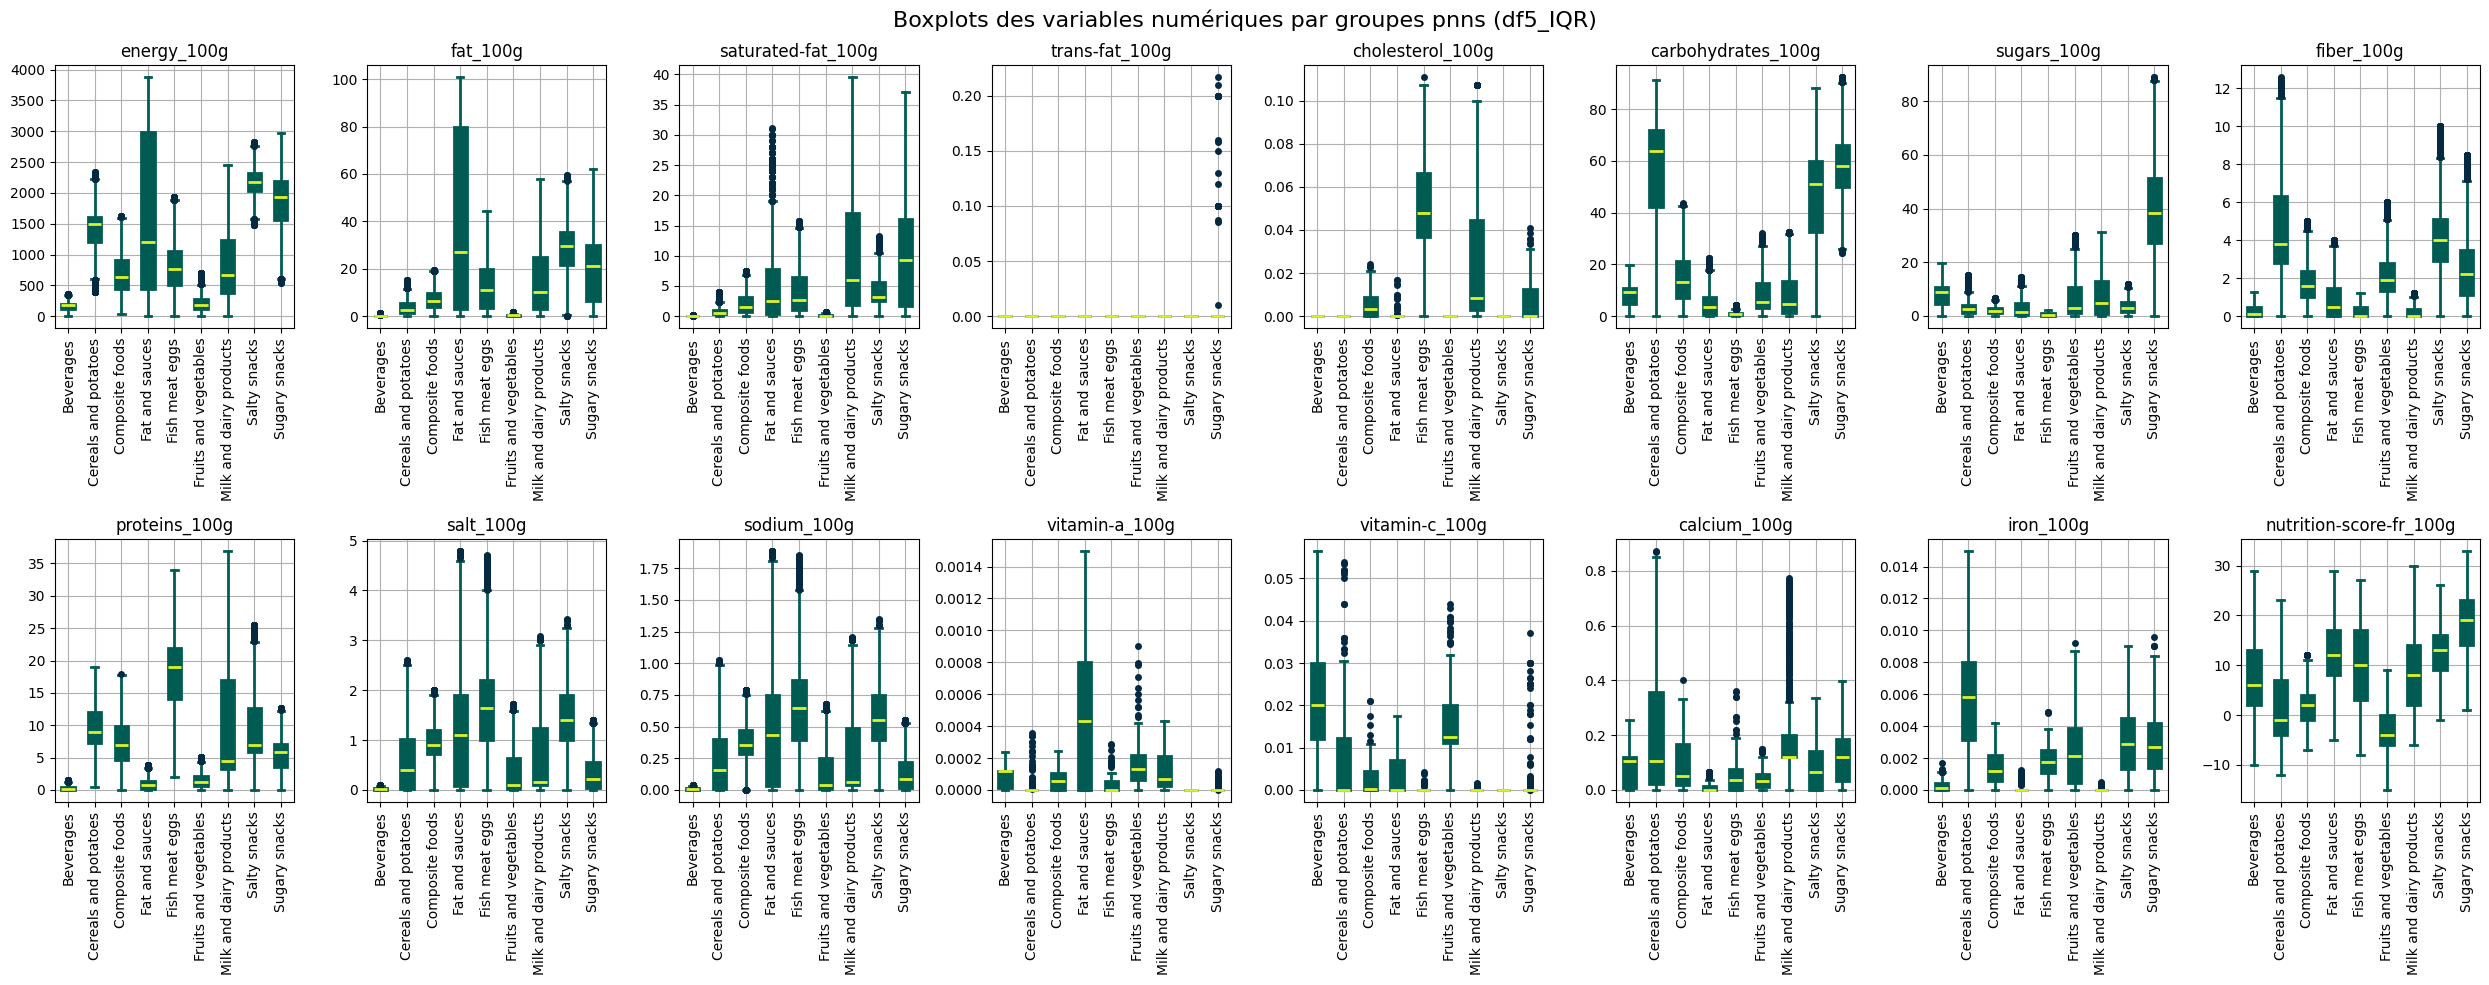

In [4]:
import matplotlib.pyplot as plt

def create_boxplots(df, df_name="DataFrame"):
    # Sélectionner les colonnes numériques
    num_cols = 8
    num_rows = int(np.ceil(len(df.select_dtypes(include=['float64']).columns) / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
    axes = axes.flatten()

    # Créer les boxplots
    for i, col in enumerate(df.select_dtypes(include=['float64']).columns):
        df.boxplot(column=col, by='pnns_groups_1', ax=axes[i], patch_artist=True,
                   boxprops=dict(facecolor='#005C53', color='#005C53', linewidth=2),
                   medianprops=dict(color='#DBF227', linewidth=2),
                   whiskerprops=dict(color='#005C53', linewidth=2),
                   capprops=dict(color='#005C53', linewidth=2),
                   flierprops=dict(marker='o', markersize=5, markerfacecolor='#042940', markeredgewidth=0))
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', labelrotation=90)

    for j in range(i + 1, num_cols * num_rows):
        fig.delaxes(axes[j])

    plt.suptitle(f'Boxplots des variables numériques par groupes pnns ({df_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

create_boxplots(df5_IQR, "df5_IQR")

Les outliers ont été efficacement réduits en utilisant l'IQR par groupe PNNS, c'est plus propre pour réaliser une analyse.
Les groupes de energy_100g, fat_100g, et sugars_100g varient significativement entre les catégories, ce qui permet d'observer des différences claires entre les groupes.

In [5]:
# filtre plus aggressif pour les outliers
df6_IQR = df4_drop.copy()

# quartile
Q1 = df6_IQR.select_dtypes(include=['float64']).quantile(0.25)
Q3 = df6_IQR.select_dtypes(include=['float64']).quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

for col in df6_IQR.select_dtypes(include=['float64']).columns:
    df6_IQR.loc[(df6_IQR[col] < lower_bound[col]) | (df6_IQR[col] > upper_bound[col]), col] = np.nan

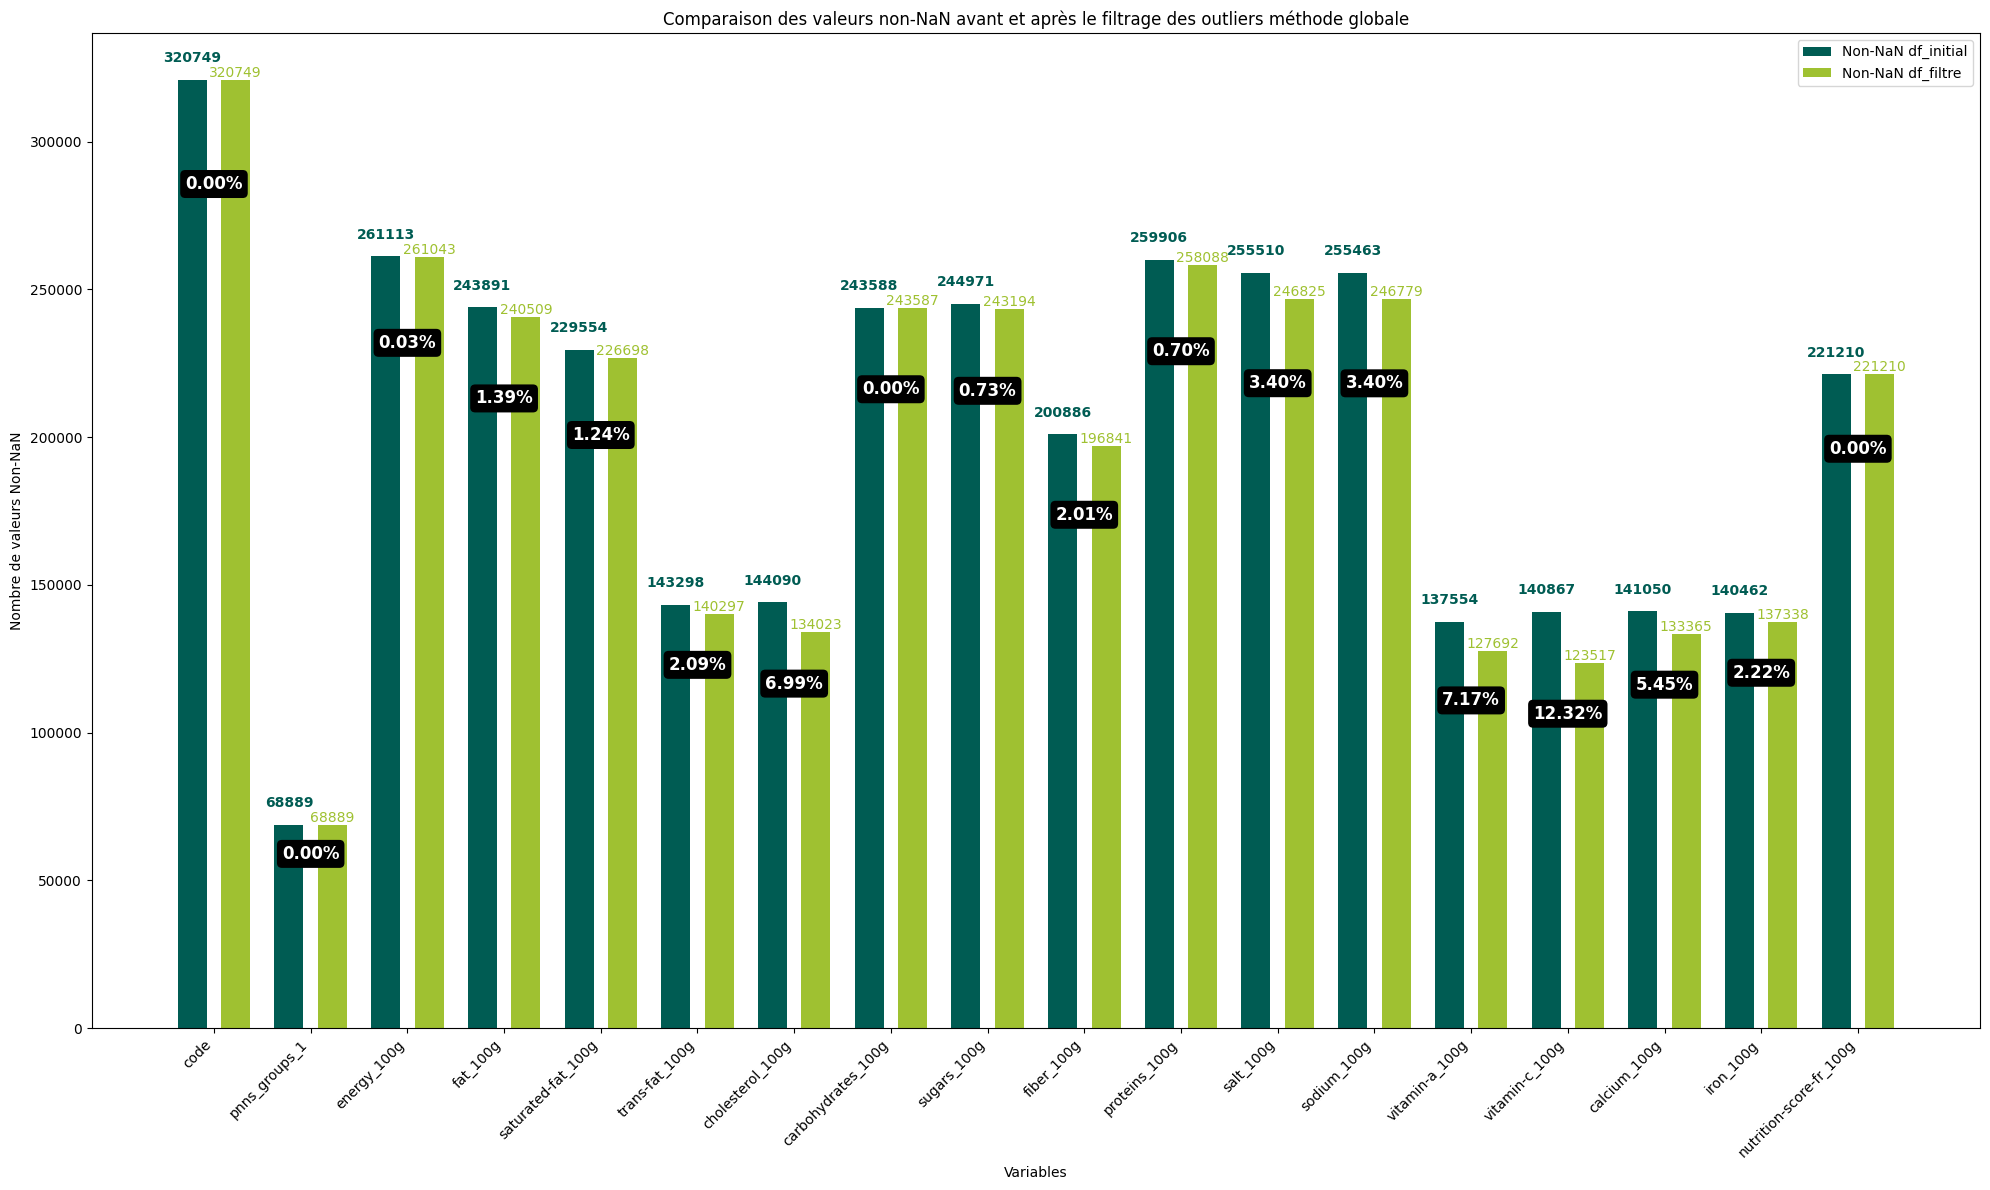

Quantité de NaN supplémentaire après traitement : 82407


In [6]:
def comparer_valeurs_non_nan(df_initial, df_filtre, titre=""):
    # Calcul des statistiques sur les NaN et non-NaN
    df_initial_non_nan = df_initial.notna().sum()
    df_filtre_non_nan = df_filtre.notna().sum()

    # Préparer les données pour le graphique
    variables = df_initial_non_nan.index
    non_nan_df_initial = df_initial_non_nan.values
    non_nan_df_filtre = df_filtre_non_nan.values

    # Calcul des pourcentages de réduction
    pourcentage_reduction = ((non_nan_df_initial - non_nan_df_filtre) / non_nan_df_initial) * 100

    # Indices pour le placement des barres
    x = np.arange(len(variables)) * 2  # Augmenter l'espacement entre les groupes de barres

    # Largeur des barres
    largeur = 0.6
    espacement_barres = 0.3  # Espacement entre les barres de chaque groupe

    # Couleurs des barres
    couleur_df_initial = '#005C53'  # Bleu foncé
    couleur_df_filtre = '#9FC131'  # Vert foncé

    # Créer le graphique pour la comparaison des non-NaN avant et après
    fig, ax = plt.subplots(figsize=(20, 12))

    # Barres pour df_initial et df_filtre côte à côte avec espacement
    bar1 = ax.bar(x - (largeur + espacement_barres)/2, non_nan_df_initial, largeur, label='Non-NaN df_initial', color=couleur_df_initial)
    bar2 = ax.bar(x + (largeur + espacement_barres)/2, non_nan_df_filtre, largeur, label='Non-NaN df_filtre', color=couleur_df_filtre)

    # Ajouter des étiquettes de données et des commentaires sur les pourcentages de réduction
    for i in range(len(variables)):
        # Réhausser uniquement les étiquettes de données des barres df_initial
        ax.text(x[i] - (largeur + espacement_barres)/2, non_nan_df_initial[i] + 5000, str(non_nan_df_initial[i]), ha='center', va='bottom', fontsize=10, color=couleur_df_initial, fontweight='bold')
        # Laisser les étiquettes de données des barres df_filtre à leur position d'origine
        ax.text(x[i] + (largeur + espacement_barres)/2, non_nan_df_filtre[i], str(non_nan_df_filtre[i]), ha='center', va='bottom', fontsize=10, color=couleur_df_filtre)
        # Ajouter les pourcentages de réduction avec une boîte noire sans bordure
        ax.text(x[i], min(non_nan_df_initial[i], non_nan_df_filtre[i]) - (max(non_nan_df_initial[i], non_nan_df_filtre[i]) * 0.10), 
                f'{pourcentage_reduction[i]:.2f}%', ha='center', va='top', color='white', fontsize=12, fontweight='bold',
                bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.3'))

    ax.set_xlabel('Variables')
    ax.set_ylabel('Nombre de valeurs Non-NaN')
    ax.set_title(f'{titre}')
    ax.set_xticks(x)
    ax.set_xticklabels(variables, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()
    
comparer_valeurs_non_nan(df4_drop, df6_IQR, "Comparaison des valeurs non-NaN avant et après le filtrage des outliers méthode globale")

# Quantité de NaN ajoutés
print(f"Quantité de NaN supplémentaire après traitement : {df6_IQR.isna().sum().sum() - df4_drop.isna().sum().sum()}")

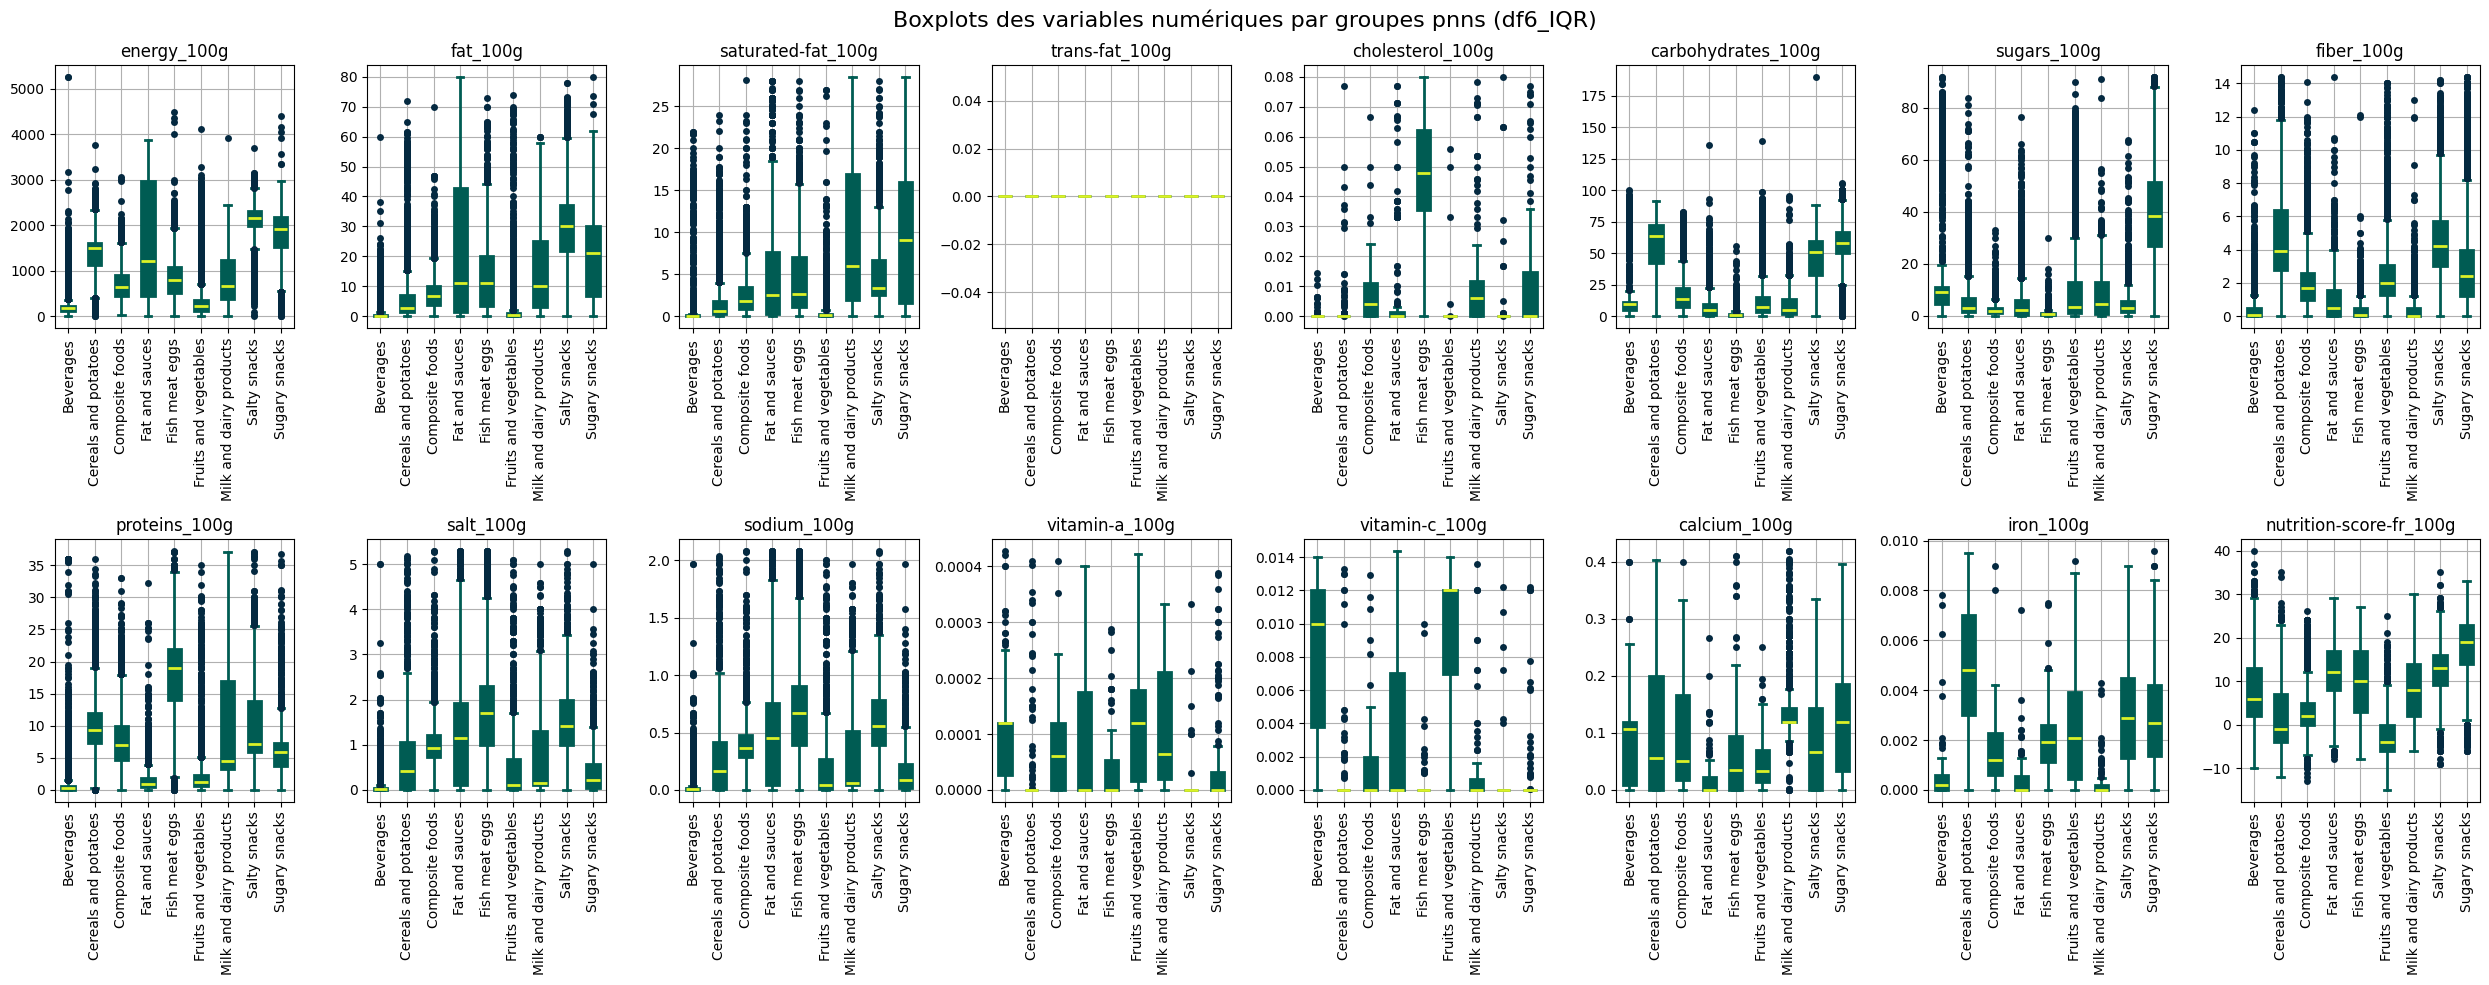

In [7]:
# box plots des variables numériques après filtrage des outliers

create_boxplots(df6_IQR, "df6_IQR")

In [8]:
# Anova sur les données bruts df5_IQR
# Réalisation d'un test de levene pour vérifier l'égalité des variances
from scipy.stats import levene

# Sélection des variables numériques et suppression des valeurs manquantes
X5 = df5_IQR.select_dtypes(include=['float64']).dropna() # Sinon il ne me prends pas les valeurs

# Réalisation du test de Levene
levene_results = levene(*[X5[col] for col in X5.columns])
print(f"Statistique de test de Levene : {levene_results.statistic}")
print(f"p-value : {levene_results.pvalue}")


Statistique de test de Levene : 316830.62073939154
p-value : 0.0


In [11]:
X5.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000,125983.000000
mean,1213.413850,13.388307,4.712595,0.068531,0.018403,35.532153,15.388648,2.856313,7.960741,1.406179,0.553613,0.000131,0.006077,0.093859,0.002409,9.397871
std,746.871811,15.482913,6.843089,1.561611,0.322713,28.176595,19.523367,4.404628,8.186271,13.989093,5.507513,0.000552,0.106699,0.837774,0.149690,9.038551
min,0.000000,0.000000,0.000000,-3.570000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000,0.000000,-0.002100,0.000000,-0.000260,-10.000000
25%,494.000000,0.820000,0.000000,0.000000,0.000000,9.090000,1.670000,0.000000,2.350000,0.142240,0.056000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1272.000000,7.780000,1.790000,0.000000,0.000000,28.570000,5.880000,1.500000,5.630000,0.741680,0.292000,0.000000,0.000000,0.035000,0.000960,10.000000
75%,1761.000000,21.430000,7.140000,0.000000,0.019000,60.710000,24.290000,3.600000,10.830000,1.450340,0.571000,0.000100,0.002100,0.100000,0.002400,17.000000
max,14644.000000,100.000000,100.000000,369.000000,95.238000,100.000000,100.000000,100.000000,100.000000,3048.000000,1200.000000,0.051818,35.714300,285.714000,50.000000,40.000000


In [9]:
# Anova One Way
from scipy import stats
f_statistic, p_values = stats.f_oneway(*[X5[col] for col in X5.columns])
print(f"Statistique de test de Fisher : {f_statistic}")

# Affichage des p-values
p_values = pd.Series(p_values, index=X5.columns)
print(p_values)

# Compte rendu de l'ANOVA
alpha = 0.05
print(f"Variables avec p-value < {alpha} :")
print(p_values[p_values < alpha])

Statistique de test de Fisher : 328424.53875791776
energy_100g                0.0
fat_100g                   0.0
saturated-fat_100g         0.0
trans-fat_100g             0.0
cholesterol_100g           0.0
carbohydrates_100g         0.0
sugars_100g                0.0
fiber_100g                 0.0
proteins_100g              0.0
salt_100g                  0.0
sodium_100g                0.0
vitamin-a_100g             0.0
vitamin-c_100g             0.0
calcium_100g               0.0
iron_100g                  0.0
nutrition-score-fr_100g    0.0
dtype: float64
Variables avec p-value < 0.05 :
energy_100g                0.0
fat_100g                   0.0
saturated-fat_100g         0.0
trans-fat_100g             0.0
cholesterol_100g           0.0
carbohydrates_100g         0.0
sugars_100g                0.0
fiber_100g                 0.0
proteins_100g              0.0
salt_100g                  0.0
sodium_100g                0.0
vitamin-a_100g             0.0
vitamin-c_100g             0.0
cal

L'anova normalement se fait sur des valeurs normales, je me suis peut être trompé dans mon analyse, j'ai décidé de ne pas l'ajouter à la présentation.
